In [531]:
import sys
sys.path.insert(0, '..')

In [532]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [533]:
wid = 64
oversample = 4

nwavels = 10
npoly=30

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)


#ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"
#fname = ddir + 'HST/n43ca5feq_cal.fits'

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


exposures = [

    #exposure_from_file(ddir + 'n8yj03tgq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

    #exposure_from_file(ddir + 'n8yj02wyq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),
    #exposure_from_file(ddir + 'n8yj02x0q_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

    #exposure_from_file(fname, SinglePointFit(), crop=wid),
    exposure_from_file(ddir + 'n8yj53vfq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),
    #exposure_from_file(ddir + 'n8yj53vfq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(ddir + 'n8yj03tiq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj53vfq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None


In [534]:
#exposures[2].target

In [535]:
exposures[0].filter

'F110W'

In [536]:
y,x = numpy.unravel_index(numpy.nanargmax(exposures[0].data),exposures[0].data.shape)
print(x,y)

31 31


In [537]:
exposures[0].filter

'F110W'

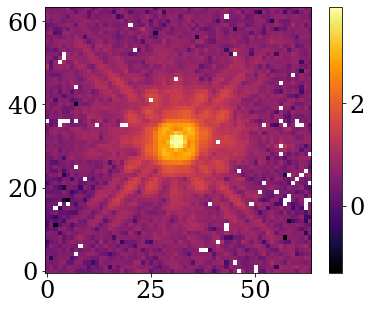

In [538]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

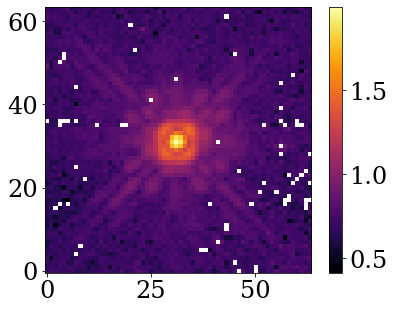

In [539]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [540]:
params = {
    "fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)#.at[0].set(1)

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [541]:
params

ModelParams(
  params={
    'fluxes':
    {'U10764_F110W': f32[]},
    'positions':
    {'n8yj53vfq': f32[2]},
    'spectrum':
    {'U10764_F110W': f32[10]},
    'aberrations':
    {'n8yj53vfq': f32[26]},
    'cold_mask_shift':
    {'n8yj53vfq': f32[2]},
    'cold_mask_rot':
    {'F110W': -45.0},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_shear':
    {'F110W': f32[2]},
    'outer_radius':
    1.146,
    'secondary_radius':
    0.44639999999999996,
    'spider_width':
    0.0924,
    'scale':
    0.0432,
    'rot':
    0.0,
    'softening':
    2.0
  }
)

In [542]:
print(params.params)

{'fluxes': {'U10764_F110W': Array(3.4618218, dtype=float32)}, 'positions': {'n8yj53vfq': Array([0., 0.], dtype=float32)}, 'spectrum': {'U10764_F110W': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)}, 'aberrations': {'n8yj53vfq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'cold_mask_shift': {'n8yj53vfq': Array([6., 6.], dtype=float32)}, 'cold_mask_rot': {'F110W': -45.0}, 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'primary_rot': {'F110W': -45.0}, 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924, 'scale': 0.0432, 'rot': 0.0, 'softening': 2.0}


In [543]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    "cold_mask_shift": opt(g*500, 120),
    "cold_mask_rot": opt(g*100, 120),
    #"cold_mask_scale": opt(g*1000, 150),
    #"cold_mask_shear": opt(g*10, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*1.5,120),
    "spectrum": opt(g*0.3, 20),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [544]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [545]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [546]:
fishers

{'n8yj53vfq': {'fluxes': Array([[4.02508e+09]], dtype=float32),
  'positions': Array([[ 1.7571054e+08, -5.2450372e+07],
         [-5.2450356e+07,  1.6724272e+08]], dtype=float32),
  'cold_mask_shift': Array([[-7138841.  ,   795483.56],
         [  795483.75, -7137181.5 ]], dtype=float32),
  'cold_mask_rot': Array([[-12930474.]], dtype=float32),
  'aberrations': Array([[-7.83906348e+03,  7.33417969e+02, -1.15549011e+02,
           2.11046606e+03, -2.11072998e+03, -2.20455032e+02,
          -2.53552994e+02, -1.15250146e+03, -4.09234161e+01,
          -7.17316040e+02, -5.19980469e+02, -2.00966797e+01,
          -2.94607349e+03,  2.90612988e+03, -2.93179413e+02,
          -2.58883087e+02,  3.18858266e-01, -2.72395592e+01,
           6.31711572e+03,  5.01304565e+02,  6.88051758e+01,
           5.39240837e+00, -5.20468079e+02,  2.85568817e+02,
          -4.86276340e+00, -5.78737122e+02],
         [ 7.33421875e+02, -1.21550820e+04, -7.83891602e+01,
          -1.96592139e+03,  1.90411780e+03, 

In [547]:
lrs.params

{'aberrations': {'n8yj53vfq': Array([1.2756627e-04, 8.2270119e-05, 7.1534472e-05, 1.3542791e-04,
         1.3224052e-04, 1.6917555e-04, 1.6717655e-04, 1.7454612e-04,
         6.9949085e-05, 8.5792562e-05, 1.0201848e-04, 8.9683752e-05,
         1.2257019e-04, 1.2455109e-04, 9.8898199e-05, 9.9314653e-05,
         1.1187204e-04, 1.1178506e-04, 9.0009242e-05, 8.4489744e-05,
         6.7952038e-05, 6.5063439e-05, 7.5366472e-05, 1.1262897e-04,
         9.6927215e-05, 1.0465582e-04], dtype=float32)},
 'cold_mask_rot': {'F110W': Array(7.7336686e-08, dtype=float32)},
 'cold_mask_scale': {'F110W': None},
 'cold_mask_shear': {'F110W': None},
 'cold_mask_shift': {'n8yj53vfq': Array([1.4007875e-07, 1.4011133e-07], dtype=float32)},
 'fluxes': {'U10764_F110W': Array(-2.4844227e-10, dtype=float32)},
 'outer_radius': None,
 'positions': {'n8yj53vfq': Array([-5.6911782e-09, -5.9793335e-09], dtype=float32)},
 'primary_rot': {'F110W': None},
 'primary_scale': {'F110W': None},
 'primary_shear': {'F110W': N

In [548]:
model

NICMOSModel(
  params={
    'aberrations':
    {'n8yj53vfq': f32[26]},
    'cold_mask_rot':
    {'F110W': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'n8yj53vfq': f32[2]},
    'fluxes':
    {'U10764_F110W': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {'n8yj53vfq': f32[2]},
    'primary_rot':
    {'F110W': f32[]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'rot':
    f32[],
    'scale':
    f32[],
    'secondary_radius':
    f32[],
    'softening':
    f32[],
    'spectrum':
    {'U10764_F110W': f32[10]},
    'spider_width':
    f32[]
  },
  filters={'F110W': f32[15,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          translation=None,
          rotation=f32[],
          compression=None,
   

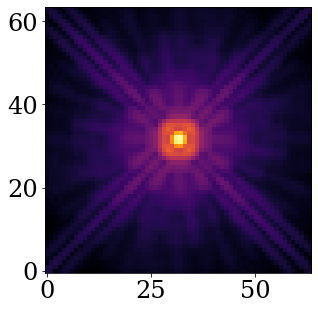

In [549]:
plt.imshow(exposures[0].fit(model,exposures[0])**0.125)

In [550]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(600)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)
    
    #if i == 200:
    #    params.set("softening", 0.2)

    #params = params.set("spectrum.U10764_F110W", params.get("spectrum.U10764_F110W")/np.sum(params.get("spectrum.U10764_F110W")))

    models.append(params)
    losses.append(loss)


  0%|          | 0/600 [00:00<?, ?it/s]

In [551]:
#model


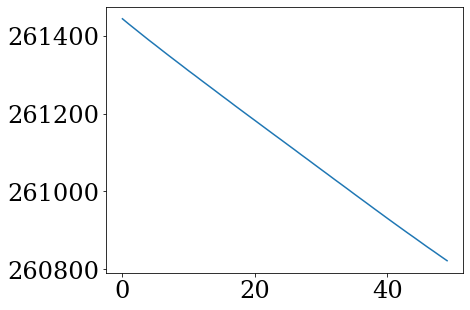

In [552]:
plt.plot(losses[-50:])

6


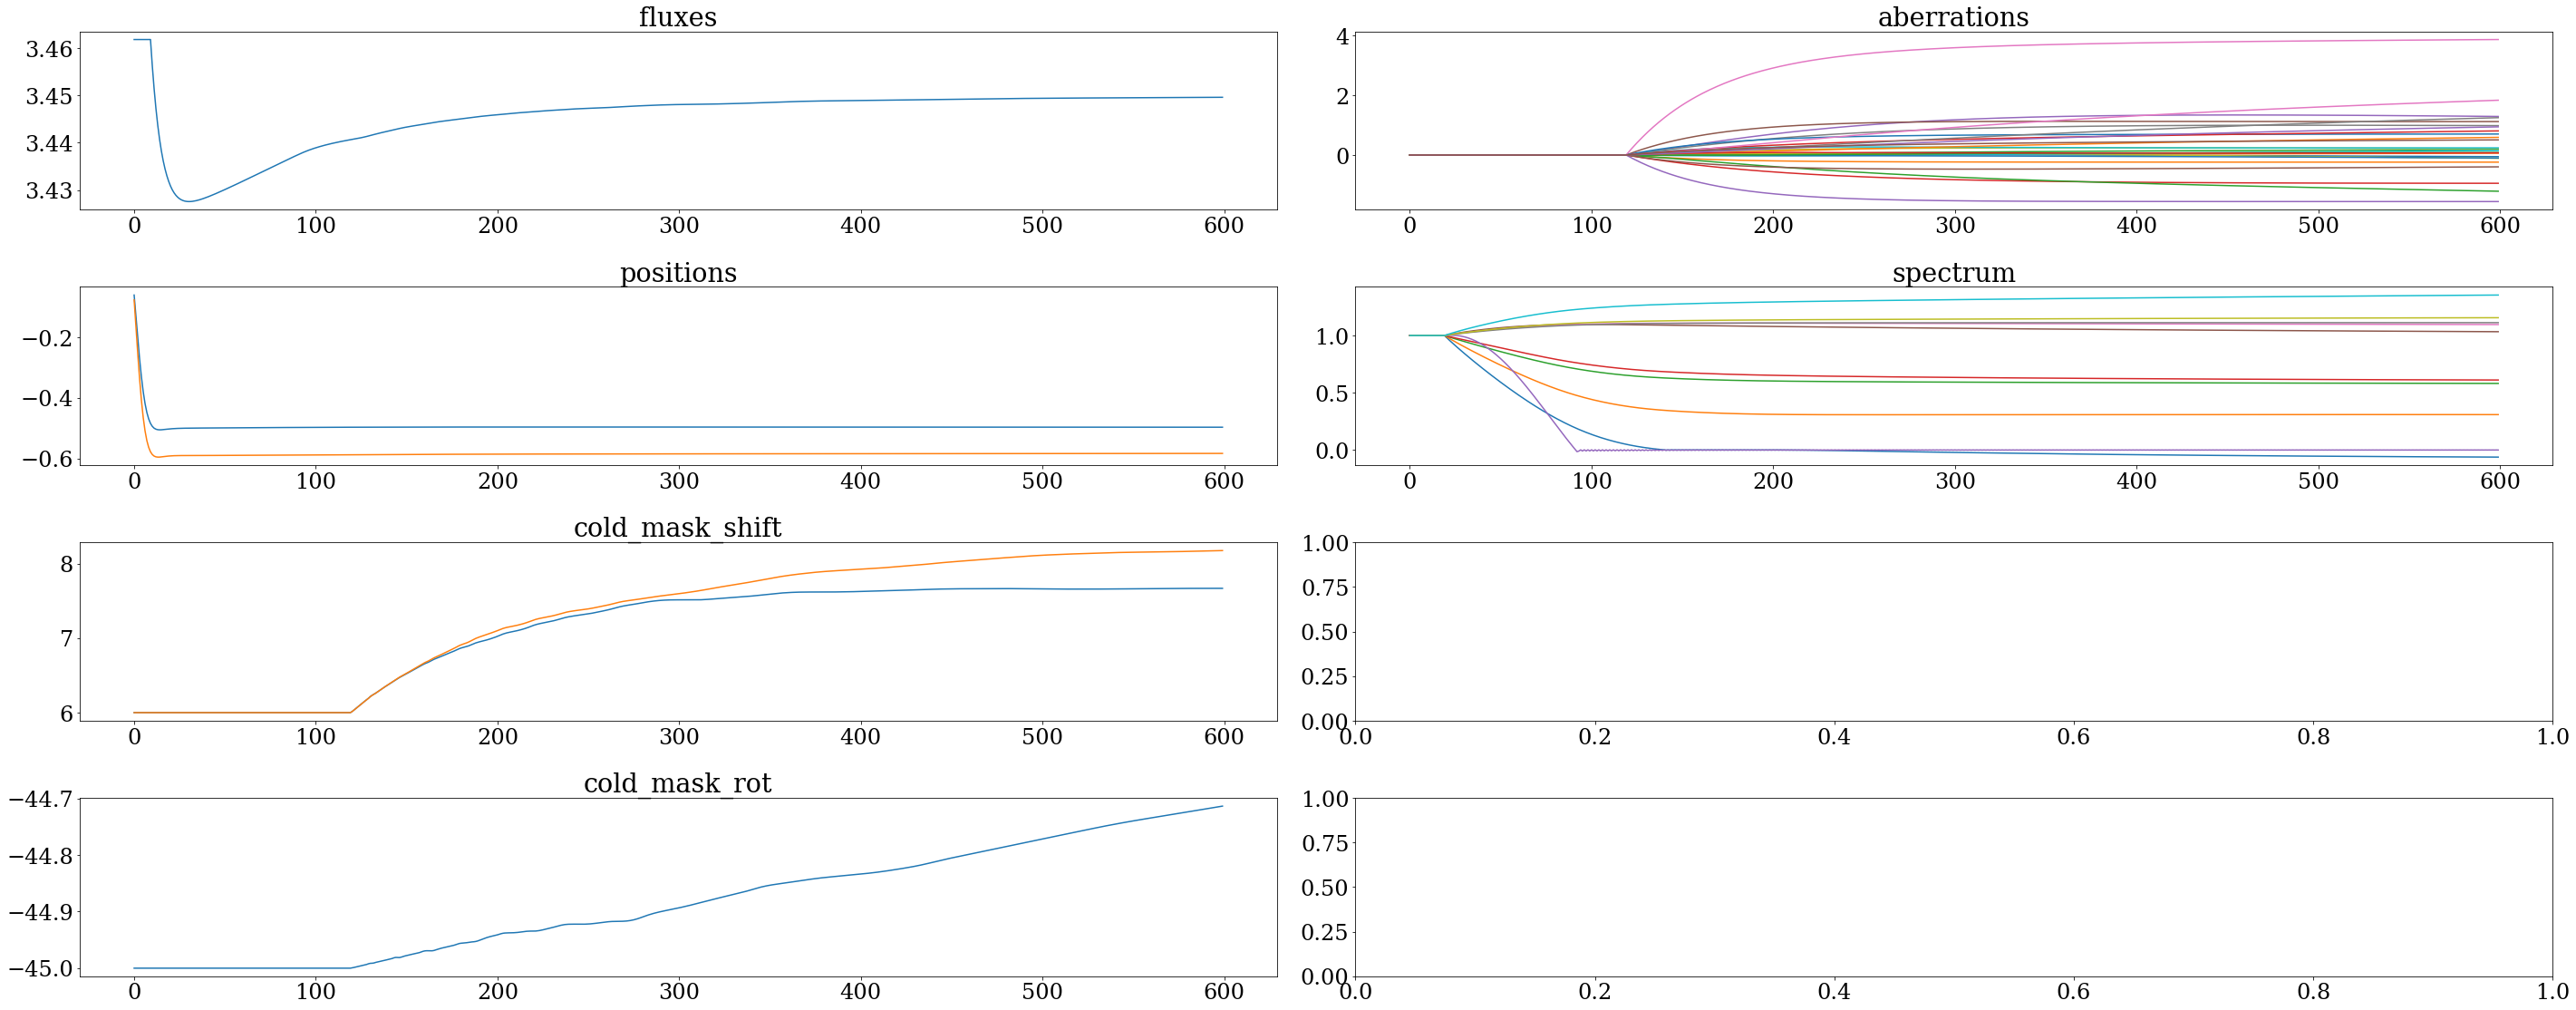

In [553]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "breathing", "slope", "spectrum"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

In [554]:
#for exp in exposures:
#    params = params.set("aberrations."+exp.fit.get_key(exp, "aberrations"), -params.get("aberrations."+exp.fit.get_key(exp, "aberrations")))

9.679346e+07, 2.608217e+05


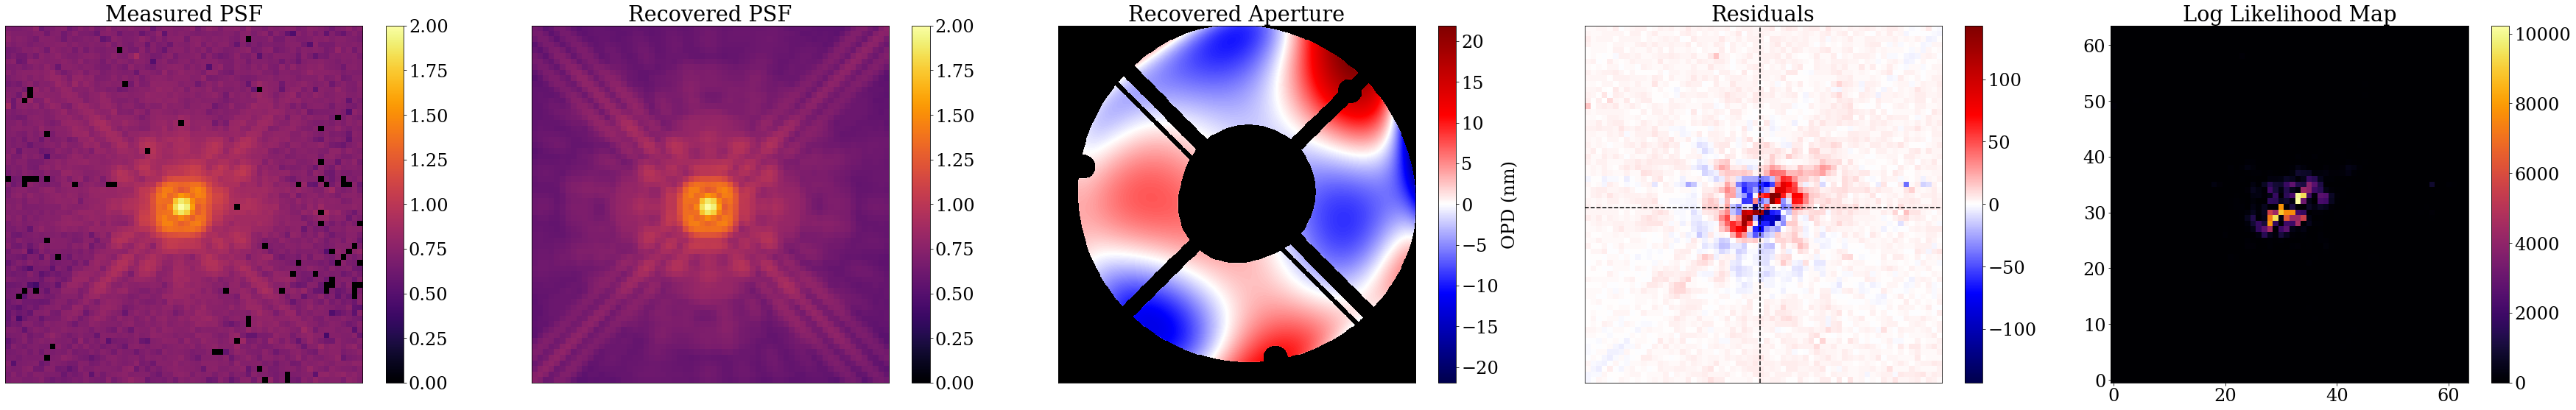

In [555]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,5, figsize=(50,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]


model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

#start_aberrations = model.get(exp.fit.map_param(exp, "start_aberrations"))#*1e-9
#end_aberrations = model.get(exp.fit.map_param(exp, "end_aberrations"))#*1e-9

#aberrations_model = model.set(exp.map_param("aberrations"), (start_aberrations+end_aberrations)/2)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[3].axvline((wid-1)/2 + params.get(exp.map_param("positions"))[0], color='k',linestyle='--')
axs[3].axhline((wid-1)/2 + params.get(exp.map_param("positions"))[1], color='k',linestyle='--')


lpdf = posterior(model,exp,return_im=True)#*nanmap
lpd = axs[4].imshow(lpdf)
plt.colorbar(lpd, ax=axs[4])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")
axs[4].set_title("Log Likelihood Map")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [556]:
params.get("spectrum.U10764_F110W")

Array([-6.1975364e-02,  3.0904984e-01,  5.8149493e-01,  6.1131895e-01,
       -2.4645589e-04,  1.0332184e+00,  1.0956218e+00,  1.1123348e+00,
        1.1552868e+00,  1.3533369e+00], dtype=float32)

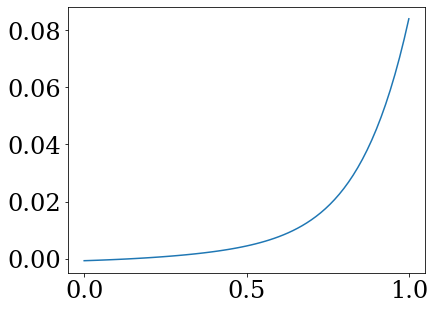

In [557]:
wv = filter_files["F110W"][:,0]/1e10
wmax = np.max(wv)
wmin = np.min(wv)

swv = (wv-wmin)/(wmax-wmin)
spec = dl.PolySpectrum(swv, params.get("spectrum.U10764_F110W"))
plt.plot(swv, spec.weights)

In [558]:
params.params["spectrum"]

{'U10764_F110W': Array([-6.1975364e-02,  3.0904984e-01,  5.8149493e-01,  6.1131895e-01,
        -2.4645589e-04,  1.0332184e+00,  1.0956218e+00,  1.1123348e+00,
         1.1552868e+00,  1.3533369e+00], dtype=float32)}

In [559]:
#potato

In [560]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [561]:
fishers.keys()

dict_keys(['n8yj53vfq'])

In [562]:
spectrum_cov = np.linalg.inv(fishers['n8yj53vfq']['spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(spectrum_cov)))

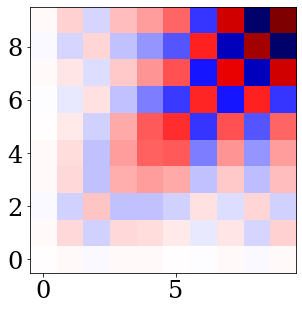

In [563]:
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))


In [564]:
params.params['spectrum']

{'U10764_F110W': Array([-6.1975364e-02,  3.0904984e-01,  5.8149493e-01,  6.1131895e-01,
        -2.4645589e-04,  1.0332184e+00,  1.0956218e+00,  1.1123348e+00,
         1.1552868e+00,  1.3533369e+00], dtype=float32)}

In [565]:
params.get("spectrum.U10764_F110W")/spectrum_err

Array([-7.4274335e+00,  7.8825459e+00,  1.1651269e+01,  1.0462342e+01,
       -3.0148304e-03,  1.0978749e+01,  1.1415448e+01,  9.9444571e+00,
        8.5245142e+00,  9.2256250e+00], dtype=float32)

In [566]:
params.params

{'aberrations': {'n8yj53vfq': Array([-0.0543677 ,  0.0596306 ,  0.18223318, -0.945262  ,  1.2883592 ,
          1.1174448 ,  3.8601599 ,  0.981565  ,  0.21934047,  0.23824482,
          0.70122087, -0.23853971, -1.2104967 ,  0.80553055, -1.5560523 ,
         -0.39578715,  1.8310124 ,  1.2480109 , -0.10910741,  0.15191495,
         -0.10098521,  0.5898277 ,  0.08380775,  0.07270407,  0.9414882 ,
          0.50566125], dtype=float32)},
 'cold_mask_rot': {'F110W': Array(-44.71371, dtype=float32)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'n8yj53vfq': Array([7.669537, 8.17668 ], dtype=float32)},
 'fluxes': {'U10764_F110W': Array(3.4496086, dtype=float32)},
 'outer_radius': 1.146,
 'positions': {'n8yj53vfq': Array([-0.49697664, -0.5834853 ], dtype=float32)},
 'primary_rot': {'F110W': -45.0},
 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'primary_shear': {'F110W': Array([

Text(0, 0.5, 'Relative Spectral Intensity')

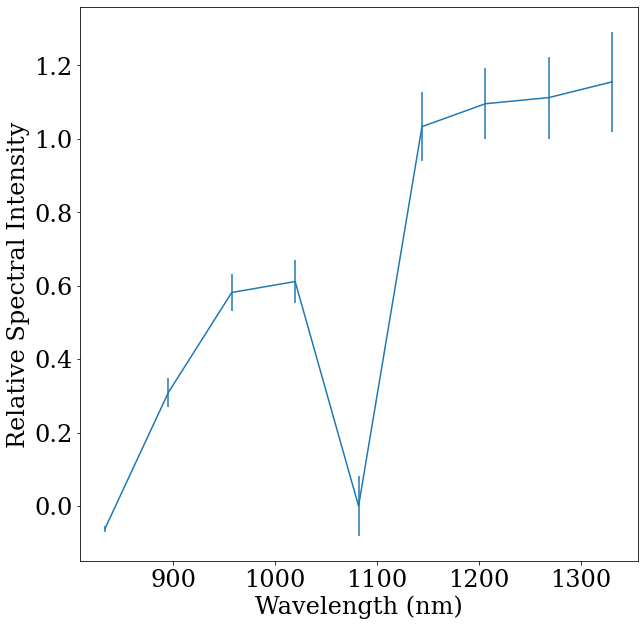

In [567]:
plt.figure(figsize=(10,10))
swv = filter_files["F110W"][:,0]/10
wmin = np.min(swv)
wmax = np.max(swv)
woff = (wmax-wmin)*0.1

wavels = np.linspace(wmin+woff, wmax-woff, nwavels)
#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.errorbar(wavels[:-1], params.get("spectrum.U10764_F110W")[:-1], yerr = spectrum_err[:-1])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [568]:
from jax.numpy import linalg as la
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [569]:
import numpy

symmetric_cov = spectrum_cov + spectrum_cov.T - np.diag(spectrum_cov.diagonal())

coeffs = numpy.random.multivariate_normal(params.get("spectrum.U10764_F110W"), nearestPD(symmetric_cov))

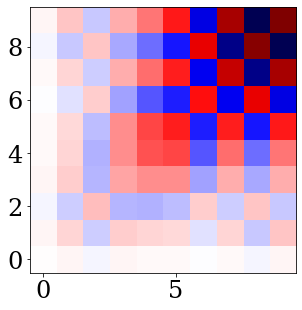

In [570]:
pdc = nearestPD(symmetric_cov)
plt.imshow(pdc, cmap='seismic', vmin=-np.max(np.abs(pdc)), vmax=np.max(np.abs(pdc)))


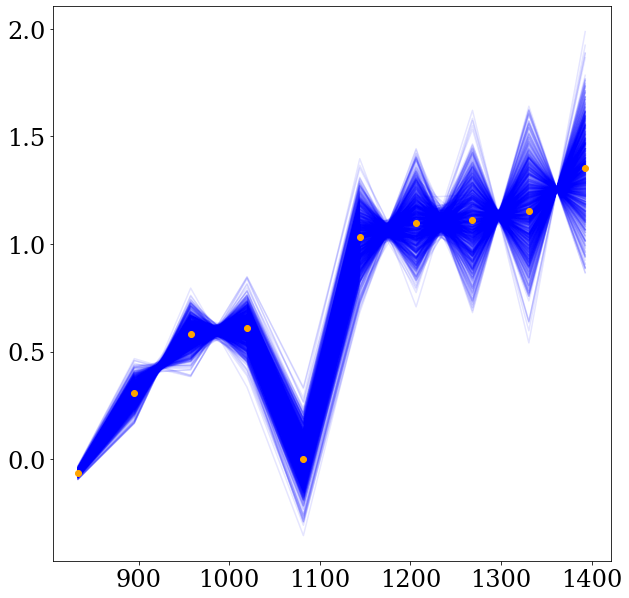

In [571]:
plt.figure(figsize=(10,10))
swv = filter_files["F110W"][:,0]/10
wmin = np.min(swv)
wmax = np.max(swv)
woff = (wmax-wmin)*0.1
wavels = np.linspace(wmin+woff, wmax-woff, nwavels)

for i in range(1000):
    coeffs = numpy.random.multivariate_normal(params.get("spectrum.U10764_F110W"), nearestPD(symmetric_cov))
    plt.plot(wavels, coeffs, color='b', alpha=0.1, zorder=0)

plt.scatter(wavels, params.get("spectrum.U10764_F110W"), color="orange", zorder=1)


In [572]:
params.get("spectrum.U10764_F110W")

Array([-6.1975364e-02,  3.0904984e-01,  5.8149493e-01,  6.1131895e-01,
       -2.4645589e-04,  1.0332184e+00,  1.0956218e+00,  1.1123348e+00,
        1.1552868e+00,  1.3533369e+00], dtype=float32)

In [573]:
spectrum_cov

Array([[ 6.96242714e-05,  3.04823712e-04, -3.23315704e-04,
         2.43618895e-04,  1.98063193e-04,  1.39218508e-04,
        -1.37528972e-04,  1.94315930e-04, -3.02659260e-04,
         3.09566880e-04],
       [ 3.04822024e-04,  1.53717736e-03, -1.87767181e-03,
         1.59071048e-03,  1.38396490e-03,  9.98703530e-04,
        -9.08003247e-04,  1.13223726e-03, -1.80671748e-03,
         1.87786412e-03],
       [-3.23318760e-04, -1.87776808e-03,  2.49083759e-03,
        -2.64970609e-03, -2.58608651e-03, -1.96562870e-03,
         1.24183577e-03, -1.48459780e-03,  1.71672844e-03,
        -1.85081270e-03],
       [ 2.43570568e-04,  1.59048871e-03, -2.64910213e-03,
         3.41411238e-03,  4.18672292e-03,  3.54293222e-03,
        -2.57374253e-03,  2.25157198e-03, -2.70404643e-03,
         2.70786975e-03],
       [ 1.97869245e-04,  1.38286059e-03, -2.58409907e-03,
         4.18529706e-03,  6.68271072e-03,  6.93862652e-03,
        -5.47037553e-03,  4.43965616e-03, -4.39212192e-03,
         4.

In [574]:
len(swv)

71